# Detect Outliers with Cleanlab and PyTorch Image Models (timm)

This quickstart tutorial shows how to detect outliers (out-of-distribution examples) in image data, using the [cifar10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset as an example. You can easily replace the image dataset + neural network used here with any other Pytorch dataset + neural network (e.g. to instead detect outliers in text data with minimal code changes). 

**Overview of what we'll do in this tutorial:**

Detect outliers using `feature_embeddings`

- Pre-process [cifar10](https://www.cs.toronto.edu/~kriz/cifar.html) into Pytorch datasets where `train_data` only contains images of animals and `test_data` contains images from all classes.

- Use a pretrained neural network model from [timm](https://github.com/rwightman/pytorch-image-models) to extract feature embeddings of each image.

- Use cleanlab to find naturally occurring outlier examples in the `train_data` (i.e. atypical images).

- Find outlier examples in the `test_data` that do not stem from training data distribution (including out-of-distribution non-animal images).

- Explore threshold selection for determining which images are outliers vs not.

Detect outliers using `pred_probs` from a trained classifier

- Adapt our [timm](https://github.com/rwightman/pytorch-image-models) network into a classifier by training an  additional output layer using the (in-distribution) training data.

- Use cleanlab to find out-of-distribution examples in the dataset based on the probabilistic predictions of this classifier, as an alternative to relying on feature embeddings.

<div class="alert alert-info">
Quickstart
<br/>
    
Already have numeric **feature embeddings** for your data? Just run the code below to score how out-of-distribution  each example is.


<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```python

from cleanlab.outlier import OutOfDistribution
    
ood = OutOfDistribution()

# To get outlier scores for train_data using feature matrix train_feature_embeddings
ood_train_feature_scores = ood.fit_score(features=train_feature_embeddings)

# To get outlier scores for additional test_data using feature matrix test_feature_embeddings
ood_test_feature_scores = ood.score(features=test_feature_embeddings)
    
    
```

</div>
    
Already have `pred_probs` and `labels` for your classification dataset? Just run the code below to to score how out-of-distribution  each example is.


<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```python

from cleanlab.outlier import OutOfDistribution
    
ood = OutOfDistribution()

# To get outlier scores for train_data using predicted class probabilities (from a trained classifier) and given class labels
ood_train_predictions_scores = ood.fit_score(pred_probs=train_pred_probs, labels=labels)

# To get outlier scores for additional test_data using predicted class probabilities
ood_test_predictions_scores = ood.score(pred_probs=test_pred_probs)
    
    
```
    
</div>
</div>

## 1. Install the required dependencies
You can use `pip` to install all packages required for this tutorial as follows:

```ipython3
!pip install matplotlib sklearn torch torchvision timm
!pip install cleanlab
...
# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install git+https://github.com/cleanlab/cleanlab.git
```

In [1]:
# Package installation (hidden on docs website).
# If running on Colab, may want to use GPU (select: Runtime > Change runtime type > Hardware accelerator > GPU)
# Package versions we used: matplotlib==3.5.1, torch==1.11.0, torchvision==0.12.0, timm==0.5.4

dependencies = ["matplotlib", "torch", "torchvision", "sklearn", "timm", "cleanlab"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install git+https://github.com/cleanlab/cleanlab.git@a0276ca587075362c3bbc5c9d56708397561ebc5
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

2022-09-11 21:57:08.821555: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.8.13/x64/lib
2022-09-11 21:57:08.821596: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Let's first import the required packages and set some seeds for reproducibility

In [2]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import torch
import torchvision
import timm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

import cleanlab
from cleanlab.outlier import OutOfDistribution

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)
# warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

## 2. Pre-process the Cifar10 dataset

Each image in the original [cifar10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) belongs to 1 of 10 classes: `[airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck]`. 
After loading the data and processing the images, we manually remove some classes from the training dataset thereby making images from these classes outliers in the test dataset. Here we to remove all classes that are not an animal, such that test images from the following classes would be out-of-distribution: `[airplane, automobile, ship, truck]`.

In [3]:
# Load cifar10 images into tensors for training (rescales pixel values to [0,1] interval):
transform_normalize = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_normalize)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_normalize)

# Define in (animal) vs out (non-animal) of distribution labels
animal_classes = [2,3,4,5,6,7]  # labels correspond to animal images
non_animal_classes = [0,1,8,9]  # labels that correspond to non-animal images

# Remove non-animal images from the training dataset
animal_idxs = np.where(np.isin(train_data.targets, animal_classes))[0]

# Only work with small subset of each dataset to speedup tutorial
train_idxs = np.random.choice(animal_idxs, len(animal_idxs) // 6, replace=False)
test_idxs = np.random.choice(range(len(test_data)), len(test_data) // 10, replace=False)

train_data  = torch.utils.data.Subset(train_data, train_idxs)  # select subset of animal images for train_data
test_data  = torch.utils.data.Subset(test_data, test_idxs)  # select subset of all images for test_data
print('train_data length: %s' % (len(train_data)))
print('test_data length: %s' % (len(test_data)))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


Files already downloaded and verified


train_data length: 5000
test_data length: 1000


#### Visualize some of the training and test examples

In [4]:
txt_classes = {0: 'airplane', 
              1: 'automobile', 
              2: 'bird',
              3: 'cat', 
              4: 'deer', 
              5: 'dog', 
              6: 'frog', 
              7: 'horse', 
              8:'ship', 
              9:'truck'}

def imshow(img):
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def plot_images(dataset, show_labels=False):
    plt.rcParams["figure.figsize"] = (9,7)
    for i in range(15):
        X,y = dataset[i]
        ax = plt.subplot(3,5,i+1)
        if show_labels:
            ax.set_title(txt_classes[int(y)])
        ax.imshow(imshow(X))
    plt.show()

def visualize_outliers(idxs, data):
    data_subset = torch.utils.data.Subset(data, idxs)
    plot_images(data_subset)

Observe how there are only animals left in our `train_data`:

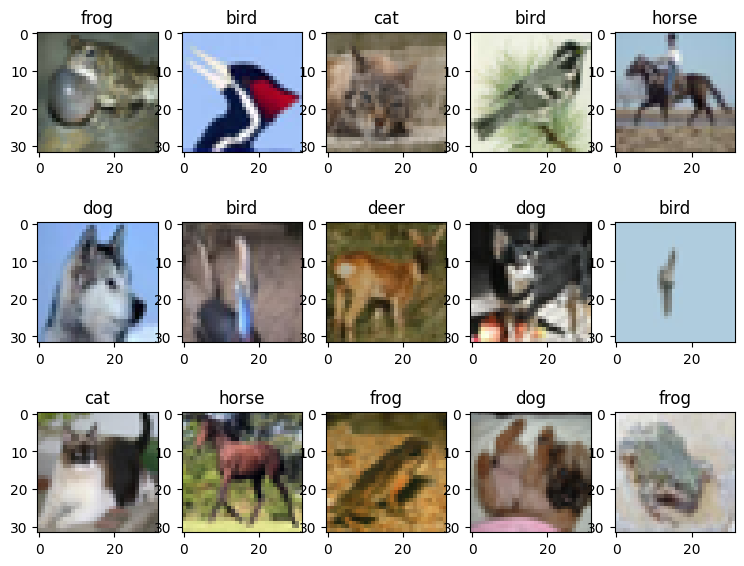

In [5]:
plot_images(train_data, show_labels=True)

If we consider `train_data` to be representative of the typical data distribution, then non-animal images in `test_data` become outliers:

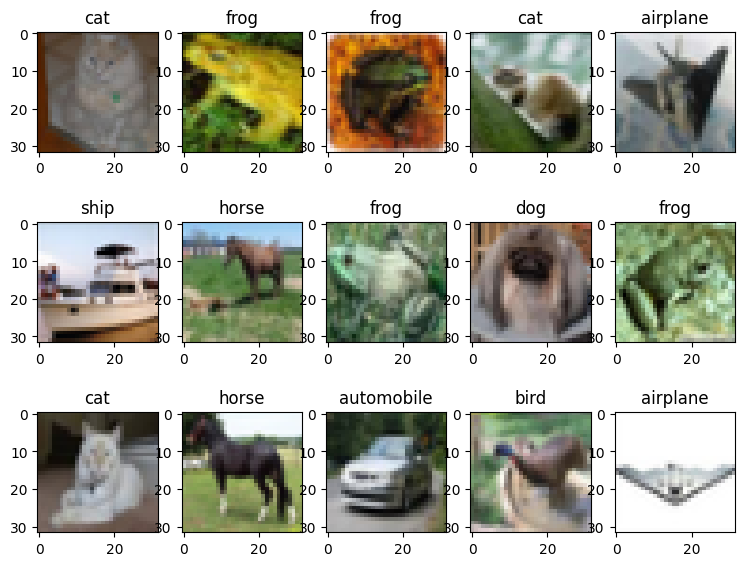

In [6]:
plot_images(test_data, show_labels=True)

## 3. Use cleanlab and feature embeddings to find outliers in the data


### Represent each image as a numeric feature embedding vector

We can pass images through a neural network to generate vector embeddings via its hidden layer representation. Here we use a `resnet50` network from [timm](https://timm.fast.ai/), which has been pretrained on a large corpus of other images. Note that cleanlab's outlier detection can be applied to feature embeddings generated from any model (or to the raw data features if they are already numeric vectors). Outlier detection works best with moderately-dimensional feature vectors, in which values along each dimension are of a similar scale. 

In [7]:
# Generates 2048-dimensional feature embeddings from images
def embed_images(model, dataloader):
    feature_embeddings = []
    for data in dataloader:
        images, labels = data
        with torch.no_grad():
            embeddings = model(images)
            feature_embeddings.extend(embeddings.numpy())
    feature_embeddings = np.array(feature_embeddings)
    return feature_embeddings  # each row corresponds to embedding of a different image

In [8]:
# Load pretrained neural network
model = timm.create_model('resnet50', pretrained=True, num_classes=0)  # this is a pytorch network
model.eval()  # eval mode disables training-time operators (like batch normalization)

# Use dataloaders to stream images through the network
batch_size = 50
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Generate feature embeddings
train_feature_embeddings = embed_images(model, trainloader)
print(f'Train embeddings pooled shape: {train_feature_embeddings.shape}')
test_feature_embeddings = embed_images(model, testloader)
print(f'Test embeddings pooled shape: {test_feature_embeddings.shape}')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /home/runner/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


Train embeddings pooled shape: (5000, 2048)


Test embeddings pooled shape: (1000, 2048)


### Scoring outliers in a given dataset (training data)

Fitting cleanlab's ``OutOfDistribution`` class on ``feature_embeddings`` will find any naturally occuring outliers in a given dataset. These examples are atypical images that look strange or different from the majority of examples in the dataset. In our case, these correspond to odd-looking images of animals that do not resemble typical animals depicted in **cifar10**. This method produces a score in [0,1] for each example, where lower values correspond to more atypical examples (more likely out-of-distribution).

Fitting OOD estimator based on provided features ...


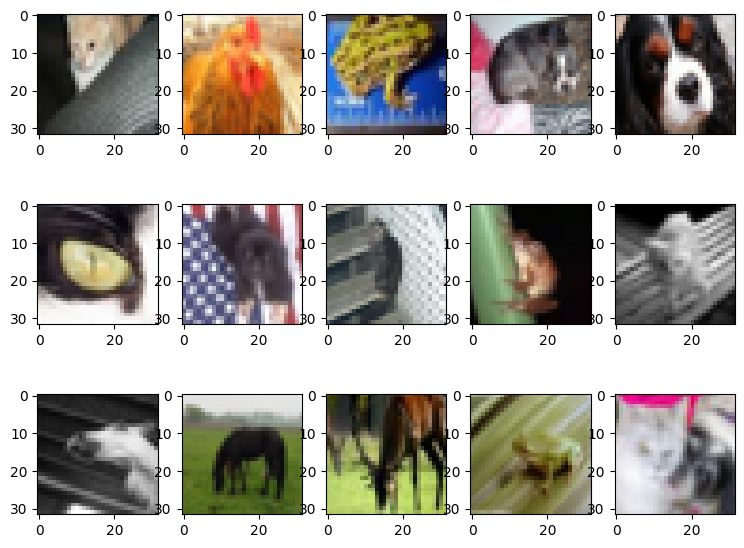

In [9]:
ood = OutOfDistribution()
train_ood_features_scores = ood.fit_score(features=train_feature_embeddings)

top_train_ood_features_idxs = train_ood_features_scores.argsort()[:15]
visualize_outliers(top_train_ood_features_idxs, train_data)

For fun, let's see what cleanlab considers the least likely outliers in the dataset! These examples look quite  homogeneous as each one is similar to many other training images.

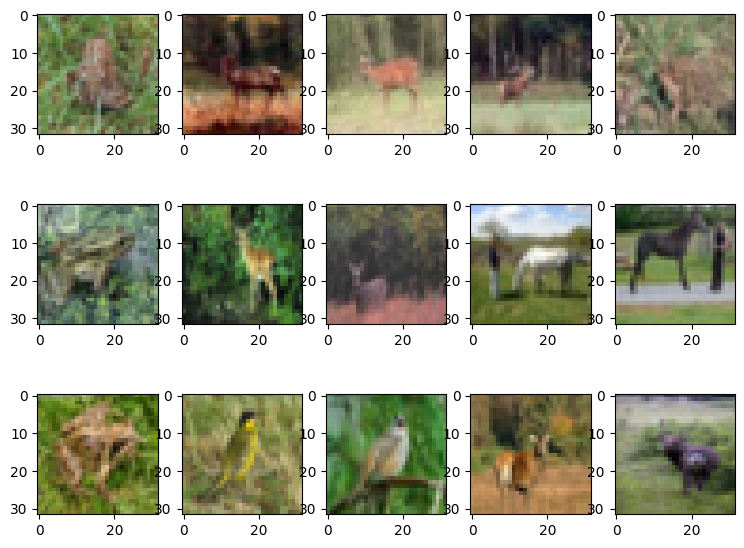

In [10]:
bottom_train_ood_features_idxs = (-train_ood_features_scores).argsort()[:15]
visualize_outliers(bottom_train_ood_features_idxs, train_data)

### Scoring outliers in additional test data

Now suppose we want to find outlier images in some never before seen test data, in particular images unlikely to stem from the same distribution as the training data. We can use our already fitted `OutOfDistribution` estimator to score how typical each new test example would be under the training data distribution and visualize the most severe outliers in this additional data.

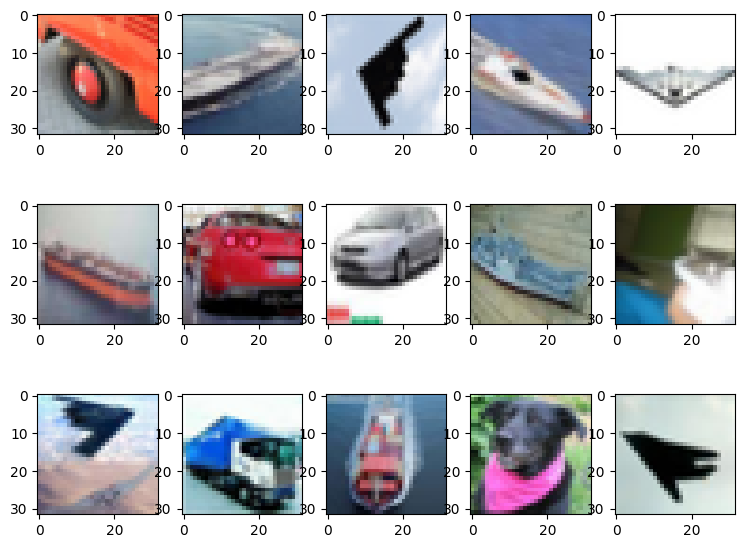

In [11]:
test_ood_features_scores = ood.score(features=test_feature_embeddings)

top_ood_features_idxs = (test_ood_features_scores).argsort()[:15]
visualize_outliers(top_ood_features_idxs, test_data)

Many outliers identified in `test_data` depict (non-animal) classes not present in the training set. These non-animal images have very different feature embeddings than the animal-only images in the training data.

### Deciding which test examples are outliers

Given outlier scores, how do we determine how many of the top-ranked examples in ``test_data`` should be marked as outliers? 

Inevitably this has some true positive / false positive trade-off, so let's suppose we want to ensure around at most 5% false positives. We can use the 5th percentile of the distribution of `train_ood_features_scores` (assuming the training data are in-distribution examples without outliers) as a hard score threshold below which to consider a test example an outlier.

Let's plot the 5th percentile of the training outlier score distribution (shown as red line).

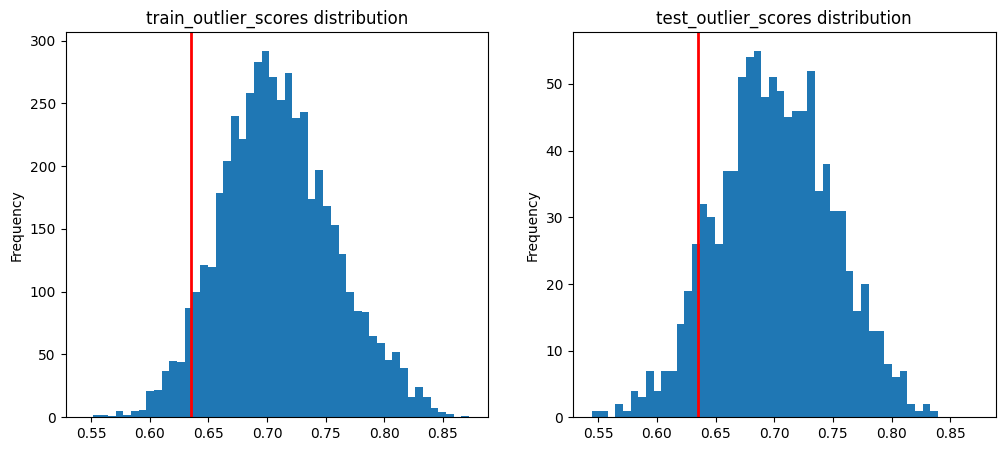

In [12]:
fifth_percentile = np.percentile(train_ood_features_scores, 5)  # 5th percentile of the train_data distribution

# Plot outlier_score distributions and the 5th percentile cutoff
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt_range = [min(train_ood_features_scores.min(),test_ood_features_scores.min()), \
             max(train_ood_features_scores.max(),test_ood_features_scores.max())]
axes[0].hist(train_ood_features_scores, range=plt_range, bins=50)
axes[0].set(title='train_outlier_scores distribution', ylabel='Frequency')
axes[0].axvline(x=fifth_percentile, color='red', linewidth=2)
axes[1].hist(test_ood_features_scores, range=plt_range, bins=50)
axes[1].set(title='test_outlier_scores distribution', ylabel='Frequency')
axes[1].axvline(x=fifth_percentile, color='red', linewidth=2)

plt.show()

All test examples whose `test_ood_features_scores` fall left of the red line will be marked as an outlier.

Let's plot the least-certain outliers of our `test_data` (i.e. 15 images with outlier scores right along the threshold). These are the images immediately to the left of that cutoff threshold (red line). The majority of them are still truly out-of-distribution non-animal images, but there are a few atypical-looking animals that are now erroneously identified as outliers as well.

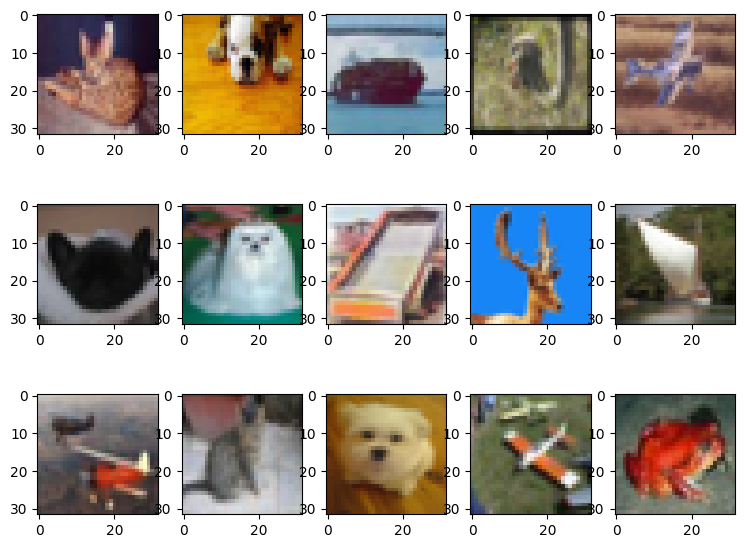

In [13]:
sorted_idxs = test_ood_features_scores.argsort()
ood_features_scores = test_ood_features_scores[sorted_idxs]
ood_features_indices = sorted_idxs[ood_features_scores < fifth_percentile]  # Images in test data flagged as outliers

visualize_outliers(ood_features_indices[::-1], test_data)

### How does cleanlab detect outliers from feature values?

Outlier scores are defined relative to the average distance (computed over feature values) between each example and its K nearest neighbors in the training data. Such scores have been found to be particularly effective for out-of-distribution detection, see this paper for more details:

[Back to the Basics: Revisiting Out-of-Distribution Detection Baselines](https://arxiv.org/abs/2207.03061)


Internally, cleanlab uses the `sklearn.neighbors.NearestNeighbor` class (with *cosine* distance) to find the K nearest neighbors, but you can easily use [another KNN estimator](https://github.com/cleanlab/examples/blob/master/9_outlier_detection_cifar10/outlier_detection.ipynb) with cleanlab's `OutOfDistribution` class.

## 5. Use cleanlab and `pred_probs` to find outliers in the data

We sometimes wish to find outliers in classification datasets for which we do not have meaningful numeric feature representations. In this case, cleanlab can detect unusual examples in the data solely using predicted probabilities from a trained classifier.

To get `pred_probs` here, a Logistic Regression classifier is fit using cross-validation on the already generated `train_feature_embeddings` (from our pretrained timm network) and the given label for each training image. We use a simple classifier here to quickly generate `pred_probs`, but in practice [fine-tuning the entire neural network for classification](https://github.com/cleanlab/examples/blob/master/9_outlier_detection_cifar10/outlier_detection.ipynb) will be more effective (our approach here is equivalent to only training an extra output layer appended  on top of the pretrained network). Cross-validation allows us to generate out-of-sample `pred_probs` for every example in the dataset. These are less biased reflections of the classifier's outputs on previously unseen data.  

In [14]:
# Preprocess data
train_labels = np.array(train_data.dataset.targets)[train_data.indices]
train_labels = np.unique(train_labels, return_inverse=True)[1]  # MAKE SURE to zero index training labels for sklearn
test_labels = np.array(test_data.dataset.targets)[test_data.indices]

scaler = preprocessing.StandardScaler().fit(train_feature_embeddings)
train_feature_embeddings_scaled = scaler.transform(train_feature_embeddings)
test_feature_embeddings_scaled = scaler.transform(test_feature_embeddings)

In [15]:
# Our classifier employs bagging to better account for epistemic uncertainty 
model = BaggingClassifier(LogisticRegression(max_iter=500), random_state=1, n_jobs=-1)

num_crossval_folds = 3  # for efficiency; values like 5 or 10 will generally work better
train_pred_probs = cross_val_predict(
    model,
    train_feature_embeddings_scaled,
    train_labels,
    cv=num_crossval_folds,
    method="predict_proba",
)

train_pred_labels = train_pred_probs.argmax(1)
accuracy = np.mean(train_pred_labels == train_labels)
print(f"Model accuracy on held-out train_data {accuracy}")

Model accuracy on held-out train_data 0.5664


We can use these `pred_probs` to again compute out-of-distribution scores for each image in our dataset using cleanlab's `OutOfDistribution` class.

In [16]:
ood = OutOfDistribution()
train_ood_predictions_scores = ood.fit_score(pred_probs=train_pred_probs, labels=train_labels)

Fitting OOD estimator based on provided pred_probs ...


We can repeat this for additional test data, to identify test images that do not stem from the training data distribution. Here we train another copy of the classifier, this time on the full training set (alternatively could employ the classifier from one of the previously completed cross-validation folds).

In [17]:
model.fit(train_feature_embeddings_scaled, train_labels)
test_pred_probs = model.predict_proba(test_feature_embeddings_scaled)

In [18]:
test_ood_predictions_scores = ood.score(pred_probs=test_pred_probs)

Detecting outliers based on feature embeddings can be done for arbitrary unlabeled datasets, but requires a meaningful numerical representation of the data.  Detecting outliers based on predicted probabilities applies mainly for labeled classification datasets, but can be done with any effective classifier. The effectiveness of the latter approach depends on: how much auxiliary information captured in the feature values is lost in the predicted probabilities (determined by the particular set of labels in the classification task), the accuracy of our classifier, and how properly its predictions reflect epistemic uncertainty.

In [19]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

# Verify the top identified test outliers data are mostly non-animal images
top_ood_features_subset = torch.utils.data.Subset(test_data, top_ood_features_idxs)
num_animals = len([i for i in range(len(top_ood_features_subset)) if top_ood_features_subset[i][1] in animal_classes])
non_animal_frac = 1 - (num_animals / len(top_ood_features_subset))
if non_animal_frac < 0.81:
    raise Exception(f"Not enough non-animal images amongst top-ranked outliers in test_data, only: {non_animal_frac}")

top_ood_predictions_idxs = (test_ood_predictions_scores).argsort()[:15]
top_ood_predictions_subset = torch.utils.data.Subset(test_data, top_ood_predictions_idxs)
num_animals = len([i for i in range(len(top_ood_predictions_subset)) if top_ood_predictions_subset[i][1] in animal_classes])
non_animal_frac = 1 - (num_animals / len(top_ood_predictions_subset))
if non_animal_frac < 0.50:
    raise Exception(f"Not enough non-animal images amongst top-ranked ood datapoints in test_data, only: {non_animal_frac}")